In [14]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.io import loadmat
from time import time
import rasterio
from sklearn import cluster
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_samples, silhouette_score, rand_score, adjusted_rand_score
from sklearn.metrics import mutual_info_score, adjusted_mutual_info_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.preprocessing import minmax_scale

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

in_image = r"PIMA_PIRIE_05_ref.tif"
ds = rasterio.open(in_image)
# ds
data_array = ds.read()
data = ds.read()

/Users/tusharagrawal/opt/anaconda3/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


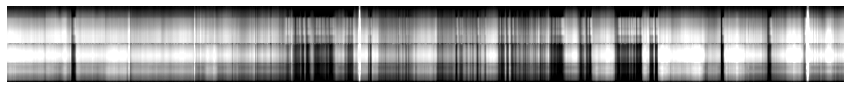

In [15]:
# Visualize
# Read and enhance
vmin, vmax = np.nanpercentile(data_array[:,:,100], (5,95)) # 5-95% pixel values stretch
# Plot the enhanced image of a spectral band
fig = plt.figure(figsize=[15,10])
plt.axis('off')
plt.imshow(data_array[:,:,100], cmap='gray', vmin=vmin, vmax=vmax)
plt.show()

In [16]:
# Reshape the input data from rcb to samples and features
data_reshaped = data_array.reshape(data_array.shape[0]*data_array.shape[1], -1)
data_reshaped = minmax_scale(data_reshaped, feature_range=(0,1), axis=0, copy=False)

In [17]:
# PCA
pca = PCA()
components = pca.fit_transform(data_reshaped)
# eigenvectors = pca.components_
eigenvalues = pca.explained_variance_
var_ratio = pca.explained_variance_ratio_

var_sum = 0
for i in range(len(var_ratio)):
    if var_sum >= 0.99:
        break
    else:
        var_sum += var_ratio[i]

selected_components = components[:,:i]

In [ ]:
# Plot the gt
def plot_data(data):
  fig = plt.figure(figsize = (25,10))
  plt.imshow(data, cmap = 'nipy_spectral')
  plt.colorbar()
  plt.axis('off')
  plt.show()

In [ ]:
# K-means
cl = cluster.KMeans(n_clusters=16) # Create an object of the classifier
components_num = 60
param = cl.fit(components[:,:components_num]) # Train
img_cl = cl.labels_ # Get the labels of the classes
# img_cl_pred = cl.predict(data_ae)
img_cl = img_cl.reshape(data_array[:,:,0].shape) # Reshape the labels to a 3D array (single band)
plot_data(img_cl)

ValueError: cannot set using a list-like indexer with a different length than the value

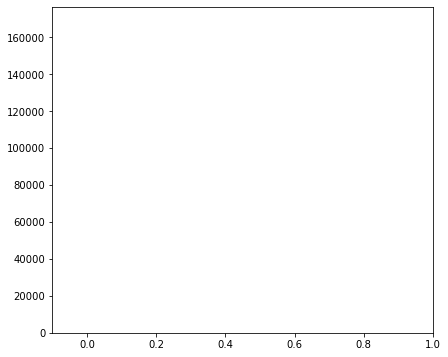

In [25]:
# Calculate different performance metrics for various numbers of clusters
range_n_clusters = list(range(15,18))
columns = ['Number of clusters', 'Calinski-Harabasz score', 'Davies-Bouldin score']
scores_pca = pd.DataFrame(np.zeros((len(range_n_clusters), len(columns))), columns=columns)

# 3D plots and different scores
for count, n_clusters in enumerate(range_n_clusters):
    # Create a subplot with 1 row and 2 columns
    fig = plt.figure(figsize=[15, 6])
    ax1 = fig.add_subplot(1, 2, 1)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(selected_components) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = cluster.KMeans(n_clusters=n_clusters, random_state=1)
    cluster_labels = clusterer.fit_predict(selected_components)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(selected_components, cluster_labels)
    
    scores_temp = [n_clusters, silhouette_avg,
                   # The resulting Calinski-Harabasz score.
                  calinski_harabasz_score(data_reshaped, clusterer.labels_),
                   # The resulting Davies-Bouldin score.
                   # The minimum score is zero, and the lower values the better clustering performance.
                  davies_bouldin_score(data_reshaped, clusterer.labels_)]
        
    scores_pca.iloc[[count]] = scores_temp

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(selected_components, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title('The silhouette plot for the various clusters.')
    ax1.set_xlabel('The silhouette coefficient values')
    ax1.set_ylabel('Cluster label')

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color='red', linestyle='--')

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    ax2 = fig.add_subplot(1, 2, 2, projection='3d')
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        selected_components[:, 0], selected_components[:, 1], selected_components[:, 2],
        marker='.', s=30, lw=0, alpha=0.7, c=colors, edgecolor='k'
    )

    ax2.set_title('The visualization of the clustered data.')
    ax2.set_xlabel('Feature space for the 1st feature')
    ax2.set_ylabel('2nd feature')
    ax2.set_zlabel('3rd feature')

    plt.suptitle(
        'Silhouette analysis for KMeans clustering on sample data with n_clusters = %d'
        % n_clusters,
        fontsize=14,
        fontweight='bold',
    )
    
    fig.subplots_adjust(wspace=0, hspace=0)

plt.show()

In [ ]:
from IPython.display import display, HTML
display(HTML(scores_pca.to_html(index=False)))

In [ ]:
# K-means
cl = cluster.KMeans(n_clusters=16, random_state=1) # Create an object of the classifier
param = cl.fit_predict(selected_components) # Train
img_cl = cl.labels_ # Get the labels of the classes
img_cl = img_cl.reshape(data_array[:,:,0].shape) # Reshape the labels to a 3D array (single band)
plot_data(img_cl)